In [26]:
#say no to warnings!
import warnings
warnings.filterwarnings("ignore")
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [27]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras.layers import InputLayer, Input, Conv2D
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.layers import MaxPool2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.backend import clear_session
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models, optimizers
from keras.callbacks import Callback
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
import seaborn as sns



In [28]:
from google.colab import drive

# Monta Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Acquisizione dati e processamento

### Carico il dataset e conto quante immagini per ogni classe ci sono nel train e nel test set

In [29]:
# Carica il dataset CIFAR-10
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Inizializza un dizionario per contare le immagini per ogni classe
train_class_counts = {i: 0 for i in range(10)}
test_class_counts = {i: 0 for i in range(10)}

# Conta le immagini per ogni classe nel train set
for label in y_train:
    train_class_counts[label[0]] += 1

# Conta le immagini per ogni classe nel test set
for label in y_test:
    test_class_counts[label[0]] += 1

# Stampa il numero di immagini per ogni classe
print("Train set class counts:")
for class_id, count in train_class_counts.items():
    print(f"Class {class_id}: {count} images")

print("\nTest set class counts:")
for class_id, count in test_class_counts.items():
    print(f"Class {class_id}: {count} images")



Train set class counts:
Class 0: 5000 images
Class 1: 5000 images
Class 2: 5000 images
Class 3: 5000 images
Class 4: 5000 images
Class 5: 5000 images
Class 6: 5000 images
Class 7: 5000 images
Class 8: 5000 images
Class 9: 5000 images

Test set class counts:
Class 0: 1000 images
Class 1: 1000 images
Class 2: 1000 images
Class 3: 1000 images
Class 4: 1000 images
Class 5: 1000 images
Class 6: 1000 images
Class 7: 1000 images
Class 8: 1000 images
Class 9: 1000 images


### Creo una funzione per eliminare le classi "ship" e "airplane" perchè non servono per il nostro task; la funzione viene applicata al train e al test set

In [30]:
def filtra_classi(label_mapping, x, y, classi_da_mantenere):
    # Converti le etichette numeriche in stringhe per visualizzazione
    y_labels_str = [label_mapping[label[0]] for label in y]

    # Crea un array con le etichette numeriche e stringhe
    y_with_labels = np.hstack((y, np.array(y_labels_str).reshape(-1, 1)))

    # Filtra le classi "ship" (8) e "airplane" (0) usando le etichette numeriche originali
    indices_to_keep = np.where((y != 0) & (y != 8))[0]
    x_filtered = x[indices_to_keep]
    y_filtered = y[indices_to_keep]
    y_with_labels = y_with_labels[indices_to_keep]

    class_map = {original_label: new_label for new_label, original_label in enumerate(classi_da_mantenere)}

    y_filtered = np.array([[class_map[label[0]]] for label in y_filtered])
    y_with_labels[:, 0] = np.ravel(y_filtered)

    return x_filtered, y_filtered, y_with_labels

# Mappatura delle etichette numeriche alle etichette stringa
label_mapping = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}

classi_da_mantenere = [1, 2, 3, 4, 5, 6, 7, 9]

x_train, y_train, y_train_with_labels = filtra_classi(label_mapping, x_train, y_train, classi_da_mantenere)
x_test, y_test, y_test_with_labels = filtra_classi(label_mapping, x_test, y_test, classi_da_mantenere)

# scaling di x_train
x_train = x_train / 255.0
x_test = x_test / 255.0


### I tensori ottenuti hanno le seguenti dimensioni:

In [31]:
print("shape di x train: ")
print(x_train.shape)
print("\nshape di y train: ")
print(y_train.shape)
print("\nshape di x test: ")
print(x_test.shape)
print("\nshape di y test: ")
print(y_test.shape)


shape di x train: 
(40000, 32, 32, 3)

shape di y train: 
(40000, 1)

shape di x test: 
(8000, 32, 32, 3)

shape di y test: 
(8000, 1)


#### Stampo un'immagine di esempio per ognuna delle classi del train set:

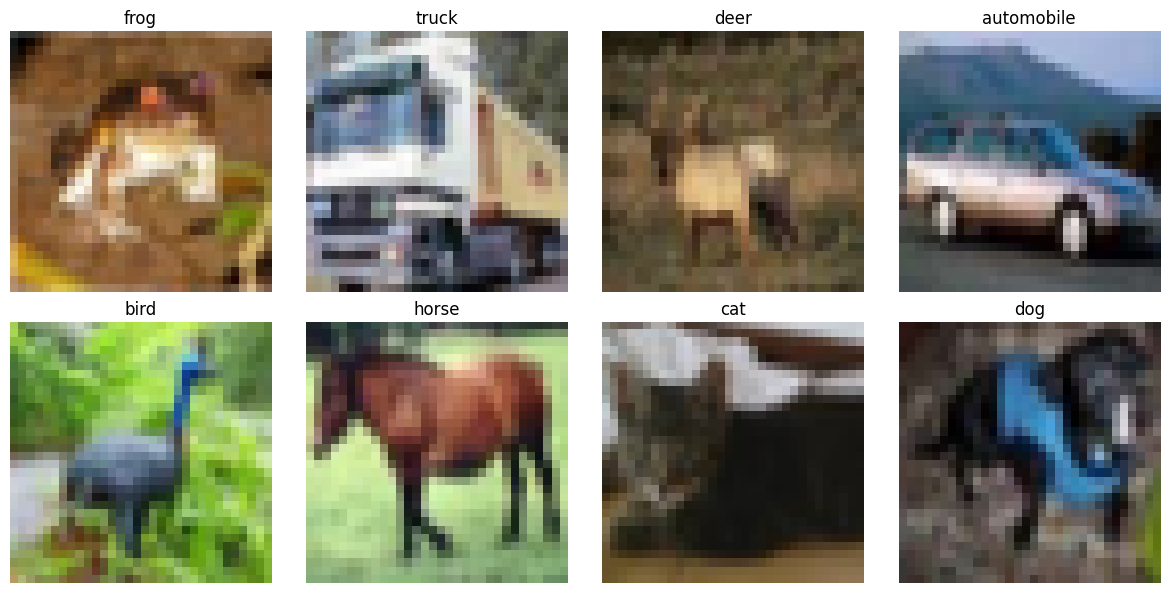

In [32]:
def print_images(x, y_with_labels):
    unique_classes = {}
    for img, (label_numeric, label_string) in zip(x, y_with_labels):
        if label_string not in unique_classes:
            unique_classes[label_string] = img
        if len(unique_classes) == 8:
            break

    fig, axes = plt.subplots(2, 4, figsize=(12, 6))

    class_items = list(unique_classes.items())

    for i, ax in enumerate(axes.flat):
        label_string, img = class_items[i]
        ax.imshow(img)
        ax.set_title(label_string)
        ax.axis('off')  # Nasconde gli assi

    plt.tight_layout()
    plt.show()

print_images(x_train, y_train_with_labels)

#### ...e del test set:

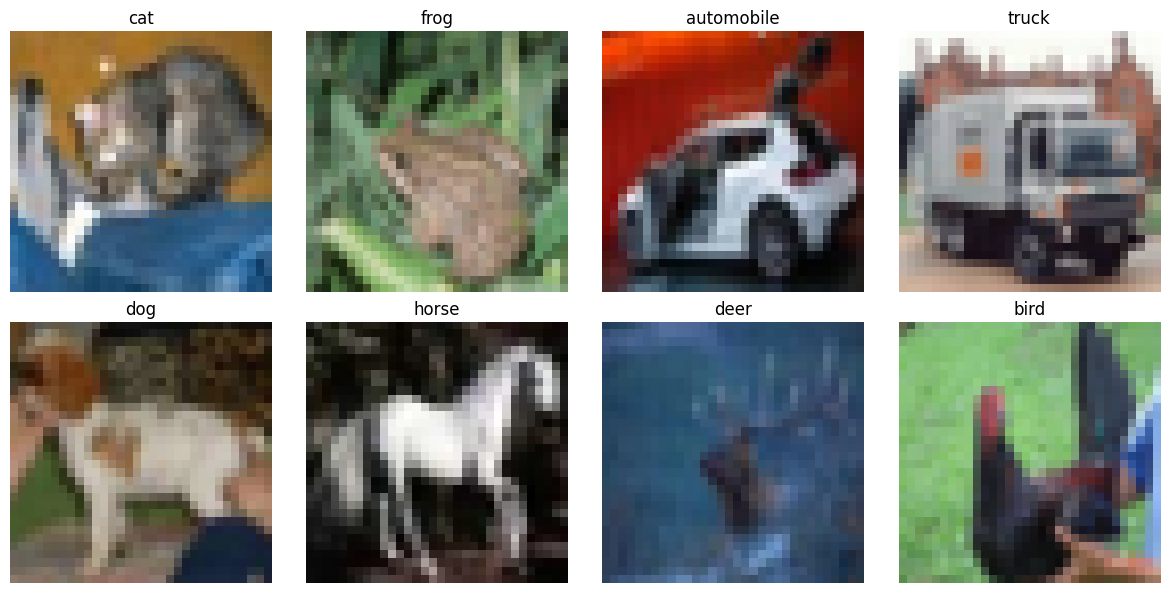

In [33]:
print_images(x_test, y_test_with_labels)

### Parametri fissi dei modelli di deep learning

In [34]:
BATCH_SIZE = 32
EPOCHS = 30

# callback per salvare i pesi dell'epoca con miglior accuracy
class BestWeightsSaver(Callback):
    def __init__(self):
        super(BestWeightsSaver, self).__init__()
        self.best_weights = None
        self.best_val_accuracy = -np.Inf

    def on_epoch_end(self, epoch, logs=None):
        val_accuracy = logs.get('val_accuracy')
        if val_accuracy is not None and val_accuracy > self.best_val_accuracy:
            self.best_val_accuracy = val_accuracy
            self.best_weights = self.model.get_weights()
            print(f"New best validation accuracy: {val_accuracy:.4f}, saving weights.")

    def on_train_end(self, logs=None):
        if self.best_weights is not None:
            print("Loading best weights from memory.")
            self.model.set_weights(self.best_weights)

# Creare l'istanza del callback
BEST_WEIGHTS_SAVER = BestWeightsSaver()

# Modello CNN base

In [35]:
num_classes = 8  # Numero di classi dopo il filtraggio

y_train_base = y_train.flatten()

model_base = Sequential([
    InputLayer(input_shape=(x_train.shape[1],x_train.shape[2],x_train.shape[3])),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPool2D(),
    #
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPool2D(),
    #
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPool2D(),
    #
    Flatten(),
    Dropout(0.2),
    Dense(1024, activation='relu'),
    Dropout(0.2),
    Dense(512, activation='relu'),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')])

model_base.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# model_base.fit(x_train, y_train_base, batch_size=BATCH_SIZE,
#                epochs=EPOCHS, validation_split=0.2, callbacks=[BEST_WEIGHTS_SAVER])

# model_base.save("/content/drive/MyDrive/Colab Notebooks/model_base.keras")

Epoch 1/30
New best validation accuracy: 0.5210, saving weights. 0s 125ms/step - accuracy: 0.4067 - loss: 1.6097  
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 142s 131ms/step - accuracy: 0.4067 - loss: 1.6094 - val_accuracy: 0.5210 - val_loss: 1.2700
Epoch 2/30
New best validation accuracy: 0.5953, saving weights. 0s 121ms/step - accuracy: 0.6103 - loss: 1.0525  
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 127s 127ms/step - accuracy: 0.6103 - loss: 1.0524 - val_accuracy: 0.5953 - val_loss: 1.0966
Epoch 3/30
New best validation accuracy: 0.6597, saving weights. 0s 113ms/step - accuracy: 0.6828 - loss: 0.8723  
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 120s 120ms/step - accuracy: 0.6828 - loss: 0.8723 - val_accuracy: 0.6597 - val_loss: 0.9696
Epoch 4/30
New best validation accuracy: 0.6984, saving weights. 0s 115ms/step - accuracy: 0.7269 - loss: 0.7487  
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 122s 121ms/step - accuracy: 0.7270 - loss: 0.7487 - val_accuracy: 0.6984 - val_loss: 0.8332
Epoch 5/30
New best validation accuracy: 0.7256,

In [11]:
def stampa_accuracy_e_CM(model, x_test, y_test, label_mapping):
  pred = model.predict(x_test)
  y_pred = np.argmax(pred, axis=1)

  accuracy = accuracy_score(y_test, y_pred)
  print(f"l'accuracy vale: {round(accuracy, 4)}\n")

  precision = precision_score(y_test, y_pred, average=None)
  for i in label_mapping.keys():
    print(f"precisione della classe {label_mapping[i]}: {str(round(precision[i], 3))}")

  print("\n")

  conf_matrix = confusion_matrix(y_test, y_pred)

  class_names = [label_mapping[i] for i in range(len(label_mapping))]

  # Step 3: Visualizzare la matrice di confusione colorata
  plt.figure(figsize=(10, 8))
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='coolwarm', cbar=False,
              xticklabels=class_names, yticklabels=class_names)
  plt.xlabel('Predicted Label')
  plt.ylabel('True Label')
  plt.title('Confusion Matrix')
  plt.show()

  return y_pred

#### Performance modello CNN base

250/250 ━━━━━━━━━━━━━━━━━━━━ 17s 65ms/step
l'accuracy vale: 0.7949

precisione della classe automobile: 0.93
precisione della classe bird: 0.712
precisione della classe cat: 0.633
precisione della classe deer: 0.723
precisione della classe dog: 0.732
precisione della classe frog: 0.892
precisione della classe horse: 0.845
precisione della classe truck: 0.915




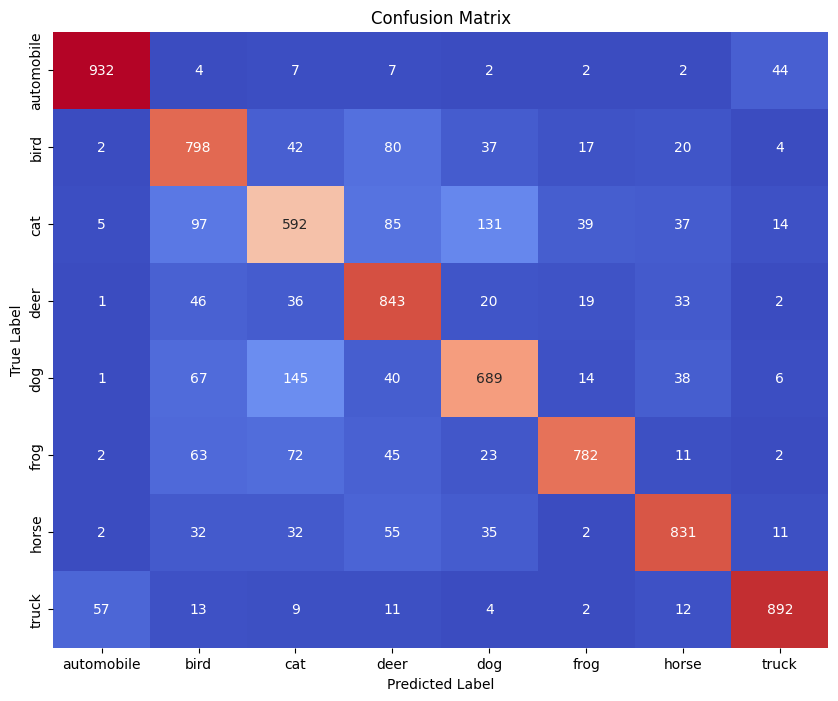

array([2, 5, 5, ..., 4, 0, 6])

In [12]:
y_test_base = y_test.flatten()

filtered_label_mapping = {
    0: 'automobile',
    1: 'bird',
    2: 'cat',
    3: 'deer',
    4: 'dog',
    5: 'frog',
    6: 'horse',
    7: 'truck'
}

model_base = load_model('/content/drive/MyDrive/Colab Notebooks/model_base.keras')

stampa_accuracy_e_CM(model_base, x_test, y_test_base, filtered_label_mapping)

# Modello DenseNet adattato per CIFAR-10

#### Creiamo un modello che, da letteratura, ha un'architettura che si presta particolarmente al task cifar10

#### Funzioni per la creazione del modello

In [36]:
def dense_block(x, blocks, name):
    for i in range(blocks):
        x = conv_block(x, 32, name=name + '_block' + str(i + 1))
    return x

def transition_block(x, reduction, name):
    x = layers.BatchNormalization(axis=3, epsilon=1.001e-5, name=name + '_bn')(x)
    x = layers.Activation('relu', name=name + '_relu')(x)
    x = layers.Conv2D(int(tf.keras.backend.int_shape(x)[3] * reduction), 1,
                      use_bias=False, name=name + '_conv')(x)
    x = layers.AveragePooling2D(2, strides=2, name=name + '_pool')(x)
    return x

def conv_block(x, growth_rate, name):
    x1 = layers.BatchNormalization(axis=3, epsilon=1.001e-5, name=name + '_0_bn')(x)
    x1 = layers.Activation('relu', name=name + '_0_relu')(x1)
    x1 = layers.Conv2D(4 * growth_rate, 1, use_bias=False, name=name + '_1_conv')(x1)
    x1 = layers.BatchNormalization(axis=3, epsilon=1.001e-5, name=name + '_1_bn')(x1)
    x1 = layers.Activation('relu', name=name + '_1_relu')(x1)
    x1 = layers.Conv2D(growth_rate, 3, padding='same', use_bias=False, name=name + '_2_conv')(x1)
    x = layers.Concatenate(axis=3, name=name + '_concat')([x, x1])
    return x

def build_densenet(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, 3, padding='same', use_bias=False, name='conv1_conv')(inputs)
    x = dense_block(x, 6, name='conv2')
    x = transition_block(x, 0.5, name='pool2')
    x = dense_block(x, 12, name='conv3')
    x = transition_block(x, 0.5, name='pool3')
    x = dense_block(x, 24, name='conv4')
    x = transition_block(x, 0.5, name='pool4')
    x = dense_block(x, 16, name='conv5')

    x = layers.BatchNormalization(axis=3, epsilon=1.001e-5, name='bn')(x)
    x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
    outputs = layers.Dense(num_classes, activation='softmax', name='fc')(x)

    model = models.Model(inputs, outputs, name='densenet_cifar')
    return model

In [37]:
num_classes = 8  # Numero di classi dopo il filtraggio

y_train_cifar = to_categorical(y_train, num_classes)

model_cifar = build_densenet(input_shape=(32, 32, 3), num_classes=num_classes)

model_cifar.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
# model_cifar.fit(x_train, y_train_cifar, validation_split = 0.2,
#                 batch_size=BATCH_SIZE, epochs=EPOCHS,
#                 callbacks=[BEST_WEIGHTS_SAVER])

# model_cifar.save("/content/drive/MyDrive/Colab Notebooks/model_cifar.keras")

Epoch 1/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.3925 - loss: 1.6900New best validation accuracy: 0.5194, saving weights.
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 244s 113ms/step - accuracy: 0.3926 - loss: 1.6897 - val_accuracy: 0.5194 - val_loss: 1.3287
Epoch 2/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.6448 - loss: 0.9655New best validation accuracy: 0.6175, saving weights.
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 123s 110ms/step - accuracy: 0.6448 - loss: 0.9654 - val_accuracy: 0.6175 - val_loss: 1.0582
Epoch 3/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.7362 - loss: 0.7289New best validation accuracy: 0.6877, saving weights.
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 107s 107ms/step - accuracy: 0.7362 - loss: 0.7288 - val_accuracy: 0.6877 - val_loss: 1.0239
Epoch 4/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 144s 109ms/step - accuracy: 0.7993 - loss: 0.5732 - val_accuracy: 0.6636 - val_loss: 1.0397
Epoch 5/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.

250/250 ━━━━━━━━━━━━━━━━━━━━ 645s 2s/step
l'accuracy vale: 0.8658

precisione della classe automobile: 0.968
precisione della classe bird: 0.884
precisione della classe cat: 0.737
precisione della classe deer: 0.847
precisione della classe dog: 0.783
precisione della classe frog: 0.861
precisione della classe horse: 0.938
precisione della classe truck: 0.931




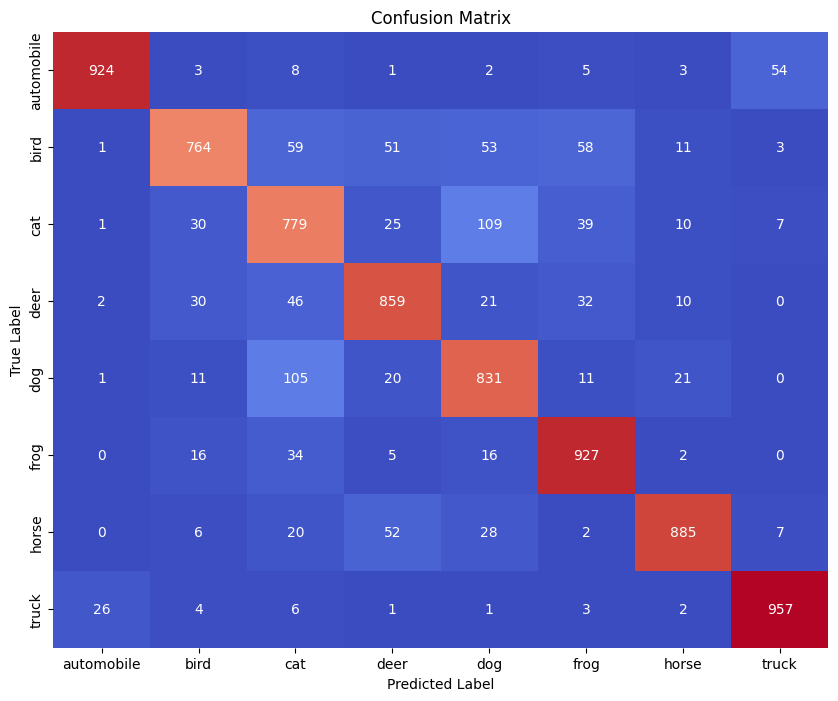

In [38]:
y_test_cifar = y_test.flatten()

filtered_label_mapping = {
    0: 'automobile',
    1: 'bird',
    2: 'cat',
    3: 'deer',
    4: 'dog',
    5: 'frog',
    6: 'horse',
    7: 'truck'
}

model_cifar = load_model("/content/drive/MyDrive/Colab Notebooks/model_cifar.keras")

y_pred_cifar = stampa_accuracy_e_CM(model_cifar, x_test, y_test_cifar, filtered_label_mapping)

#### Vediamo che la maggior parte degli errori si concentrano su classi appartenenti comunque alla stessa sovraclasse (auto/camion, cervo/cavallo, gatto/cane)

#### In particolare, la precisione dei veicoli è molto alta; la precisione più bassa si ha nelle classi "cane" e "gatto", che si scambiano spesso tra loro. Questo può esser dovuto alla somiglianza tra questi due animali (probabilmente anche dell'ambiente circostante, che spesso è un ambiente domestico), soprattutto con cosi pochi pixel di definizione che comportano la perdita dei dettagli per distinguere un cane da un gatto

#### Proviamo a valutare l'accuratezza del nostro modello sulle effettive due classi che ci interessano

In [42]:
binary_mapping = {0: 0, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 0}

map_to_binary = np.vectorize(binary_mapping.get)

# Applica il mapping agli array
y_pred_binary = map_to_binary(y_pred_cifar)
y_test_binary = map_to_binary(y_test)

accuracy_binary = accuracy_score(y_test_binary, y_pred_binary)
precision_binary = precision_score(y_test_binary, y_pred_binary, average=None)

print(f"l'accuracy per le due sovraclassi di nostro interesse vale: {round(accuracy_binary, 4)}")
binary_label_mapping = {
    0: 'veicolo',
    1: 'animale'
}
for i in binary_label_mapping.keys():
    print(f"precisione della classe {binary_label_mapping[i]}: {str(round(precision_binary[i], 3))}")


l'accuracy per le due sovraclassi di nostro interesse vale: 0.9924
precisione della classe veicolo: 0.989
precisione della classe animale: 0.994


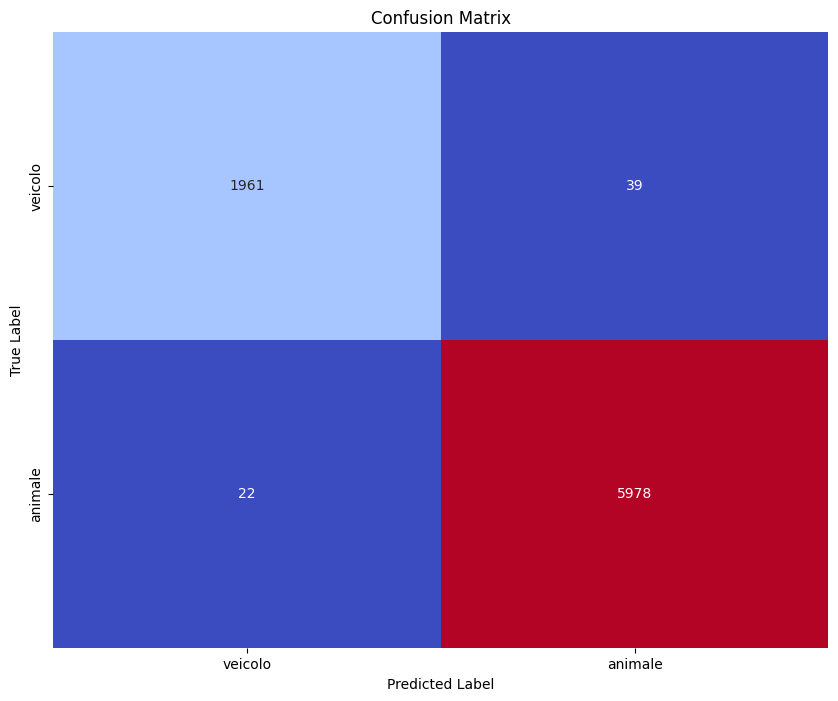

In [43]:
conf_matrix = confusion_matrix(y_test_binary, y_pred_binary)

filtered_label_mapping_binary = {
    0: 'veicolo',
    1: 'animale'
}

class_names = [filtered_label_mapping_binary[i] for i in range(len(filtered_label_mapping_binary))]

# Step 3: Visualizzare la matrice di confusione colorata
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='coolwarm', cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

#### L'accuratezza per le due sovraclassi di nostro interesse è molto alta

### Possiamo comunque ragionevolmente pensare di costruire un modello binario che distingua semplicemente le classi "veicolo" e "animale" (per quanto il risultato sia comunque ottimo cosi)

# Modello DenseNet adattato per CIFAR-10, classificazione binaria

In [18]:
binary_mapping = {0: 0, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 0}

# Applicare la mappatura al vettore di classi originali
y_train_binary = np.vectorize(binary_mapping.get)(y_train)
y_test_binary = np.vectorize(binary_mapping.get)(y_test)

# Mappatura delle etichette verso le nuove classi binarie
label_mapping = {0: 'veicoli', 1: 'animali'}
y_train_with_labels_binary = np.array([[binary_mapping[int(num)], label_mapping[binary_mapping[int(num)]]] for num, name in y_train_with_labels])
y_test_with_labels_binary = np.array([[binary_mapping[int(num)], label_mapping[binary_mapping[int(num)]]] for num, name in y_test_with_labels])


#### Stampo alcune immagini di esempio per le due sovraclassi del train set...

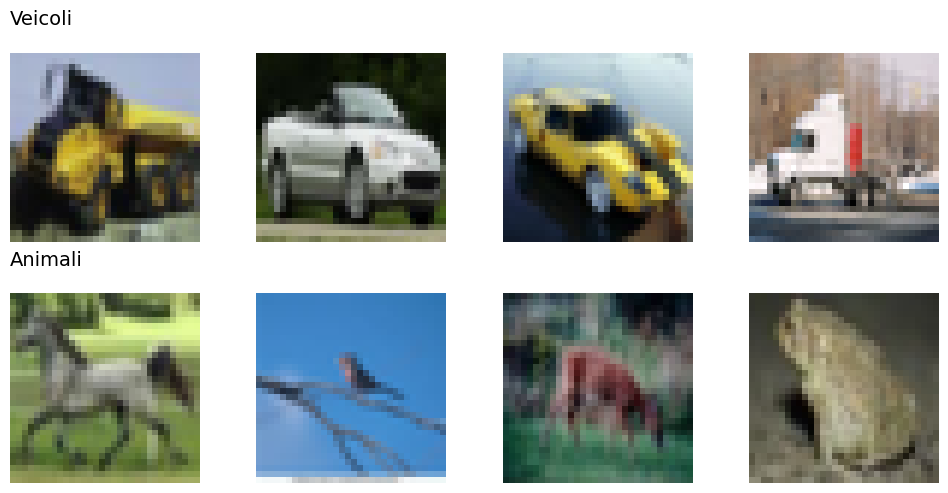

In [19]:
def print_images_binary(x, y_with_labels_binary):
  class_0_images = x[y_with_labels_binary[:, 0] == "0"]
  class_1_images = x[y_with_labels_binary[:, 0] == "1"]

  # Seleziona 4 immagini casuali da ciascuna classe
  random_indices_0 = np.random.choice(len(class_0_images), 4, replace=False)
  random_indices_1 = np.random.choice(len(class_1_images), 4, replace=False)

  selected_images_0 = class_0_images[random_indices_0]
  selected_images_1 = class_1_images[random_indices_1]

  # Imposta la figura per la visualizzazione
  fig, axes = plt.subplots(2, 4, figsize=(10, 5))

  # Mostra le immagini della classe 0
  for i, ax in enumerate(axes[0]):
      ax.imshow(selected_images_0[i], cmap='gray')  # Usa cmap='gray' se le immagini sono in scala di grigi
      ax.axis('off')  # Nasconde gli assi
  axes[0, 0].set_title('Veicoli', loc='left', fontsize=14, pad=20)

  # Mostra le immagini della classe 1
  for i, ax in enumerate(axes[1]):
      ax.imshow(selected_images_1[i], cmap='gray')  # Usa cmap='gray' se le immagini sono in scala di grigi
      ax.axis('off')  # Nasconde gli assi
  axes[1, 0].set_title('Animali', loc='left', fontsize=14, pad=20)

  # Mostra la figura
  plt.tight_layout()
  plt.show()

print_images_binary(x_train, y_train_with_labels_binary)


#### e per alcune immagini del test set

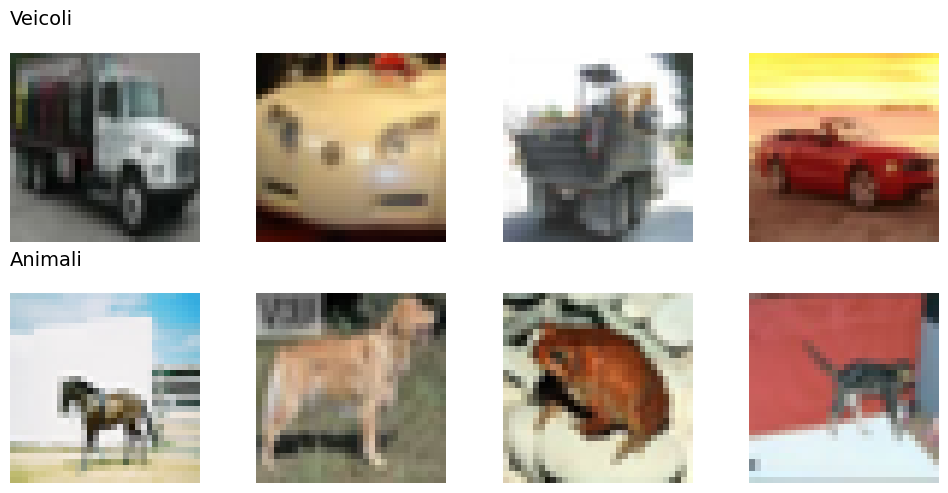

In [20]:
print_images_binary(x_test, y_test_with_labels_binary)

In [21]:
# Calcola i pesi delle classi per ridurre i problemi di sbilanciamento
class_weights = class_weight.compute_class_weight('balanced',
                                                  classes=np.unique(y_train_binary.ravel()),
                                                  y=y_train_binary.ravel())
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

In [22]:
num_classes = 2  # Numero di classi attuale

y_train_model_binary = to_categorical(y_train_binary, num_classes)

model_binary = build_densenet(input_shape=(32, 32, 3), num_classes=num_classes)

model_binary.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
# model_binary.fit(x_train, y_train_model_binary, batch_size=BATCH_SIZE, epochs=EPOCHS,
#                  validation_split = 0.2, class_weight=class_weight_dict,
#                  callbacks=[BEST_WEIGHTS_SAVER])

# model_binary.save("/content/drive/MyDrive/Colab Notebooks/model_binary.keras")


Epoch 1/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.8639 - loss: 0.3785New best validation accuracy: 0.8677, saving weights.
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 252s 120ms/step - accuracy: 0.8640 - loss: 0.3783 - val_accuracy: 0.8677 - val_loss: 0.3254
Epoch 2/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.9483 - loss: 0.1424New best validation accuracy: 0.9510, saving weights.
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 115s 109ms/step - accuracy: 0.9483 - loss: 0.1424 - val_accuracy: 0.9510 - val_loss: 0.1272
Epoch 3/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 142s 109ms/step - accuracy: 0.9582 - loss: 0.1159 - val_accuracy: 0.8494 - val_loss: 0.3639
Epoch 4/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 143s 110ms/step - accuracy: 0.9671 - loss: 0.0901 - val_accuracy: 0.9245 - val_loss: 0.1920
Epoch 5/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.9706 - loss: 0.0856New best validation accuracy: 0.9776, saving weights.
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 141s 109ms/step - accuracy

250/250 ━━━━━━━━━━━━━━━━━━━━ 589s 2s/step
l'accuracy vale: 0.9886

precisione della classe veicolo: 0.974
precisione della classe animale: 0.994




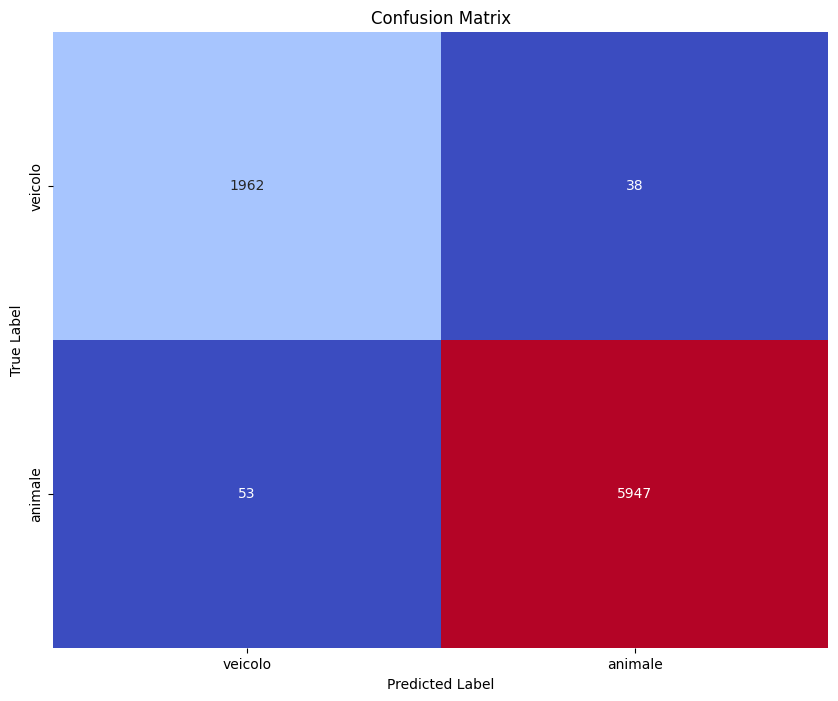

array([1, 1, 1, ..., 1, 0, 1])

In [23]:
binary_label_mapping = {
    0: 'veicolo',
    1: 'animale'
}

model_binary = load_model('/content/drive/MyDrive/Colab Notebooks/model_binary.keras')

stampa_accuracy_e_CM(model_binary, x_test, y_test_binary, binary_label_mapping)

#### Anche se con leggere differenze (in particolare per i veicoli), la soluzione migliore sembra quella di fare la previsione di ogni singola classe e successivamente distinguere tra veicolo ed animale

#### L'architettura della rete migliore è quindi:

In [44]:
model_cifar.summary()

Model: "densenet_cifar"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 32, 32, 64)     │          1,728 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 32, 32, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 32, 32, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 32, 32, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 32, 32, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 32, 32, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 32, 32, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 32, 32, 96)     │              0 │ conv1_conv[0][0],      │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block2_0_bn         │ (None, 32, 32, 96)     │            384 │ conv2_block1_concat[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block2_0_relu       │ (None, 32, 32, 96)     │              0 │ conv2_block2_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block2_1_conv       │ (None, 32, 32, 128)    │         12,288 │ conv2_block2_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block2_1_bn         │ (None, 32, 32, 128)    │            512 │ conv2_block2_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block2_1_relu  

 Total params: 20,946,266 (79.90 MB)

 Trainable params: 6,954,248 (26.53 MB)

 Non-trainable params: 83,520 (326.25 KB)

 Optimizer params: 13,908,498 (53.06 MB)